In [2]:
from numpy import arange, nan
from matplotlib import pylab as plt
%matplotlib inline
plt.style.use('ggplot')
from geotherm import *
        
gt = Geotherm().save()

In [3]:
def propagate_solution(tt,qt,k,dz,rhoH):
    tb = tt + qt/k * dz - rhoH * (dz)**2 / ( 2.*k )
    qb = qt - rhoH*dz
    
    return tb, qb
    
def example(t0=30, q0=41e-3, rhoH_crust = 0.5e-6, rhoH_lith = 0.03e-6, draw_plot = False):
    
    tb=t0
    qb=q0
    dz=1.0
    zmax=450
    
    depths = arange(0,zmax,dz)
    temps = []
    qs = []
    
    for z in depths:
        if z < crustal_thickness/3:
            rhoH=rhoH_crust * 0.6 * 3
            k=2.7
        elif z < 2*crustal_thickness/3:
            rhoH=rhoH_crust * 0.34 * 3
            k=2.7
        elif z < 3*crustal_thickness/3:
            rhoH=rhoH_crust * 0.06 * 3
            k=2.7
        else:
            rhoH=rhoH_lith
            k=1./(0.174+0.000265*tb) + (3.68e-10) * (tb)**3
        
        tb,qb = propagate_solution(tt=tb,qt=qb,k=k,dz=dz*1000,rhoH=rhoH)
        
        tad = Tp * (1. + alpha*g*z*1000/cp)
        if tb > tad:
            temps.append(tad)
        elif qb < 0.0:
            temps.append(nan)
        else:
            temps.append(tb)
        qs.append(qb)
      
    if draw_plot:
        plt.plot(temps,depths,lw=3, label = "%.2f $\mu$W/m$^3$" % (rhoH_crust*10**6) )
        plt.ylim(zmax,0)
    
    return depths, temps

def calculate_misfit(depths, temps, xdepths, xtemps):
    from scipy.interpolate import interp1d
    from numpy import log10
    
    fun = interp1d(depths,temps)
    
    nxeno = len(xdepths)
    
    misfit = 0
    
    for ixeno in range(nxeno):
        misfit += (xtemps[ixeno] - fun(xdepths[ixeno]))**2
        
    return log10(misfit**0.5)

def invert_for_geotherm(xdepths, xtemps, q0):
    from numpy import linspace
    from numpy.random import sample
    
    Hmin, Hmax = 0.2e-6, 1.2e-6
    
    heat_production = linspace(Hmin,Hmax,200)
    heat_flow = [q0]

    from numpy.random import choice
    from numpy import array

    nboot = 30

    optimal_q0 = []

    df0 = pd.DataFrame(columns=['rhoH','Q0'])

    for iboot in range(nboot):

        xdepths_boot = choice(xdepths, len(xdepths) )
        xtemps_boot  = choice(xtemps, len(xtemps) )

        msfts = []
        ii=0
        df = pd.DataFrame(columns=['rhoH','Q0','Misfit'])

        for rhoH_crust in heat_production:
            for q0 in heat_flow:
                depths, temps = example(rhoH_crust=rhoH_crust, q0=q0)
                msft = calculate_misfit(depths, temps, xdepths_boot, xtemps_boot)
                msfts.append(msft)
                df.loc[ii] = [rhoH_crust, q0, msft] 
                ii += 1

        df0.loc[iboot] = [df.sort_values("Misfit").iloc[0].rhoH, df.sort_values("Misfit").iloc[0].Q0]

    return df0

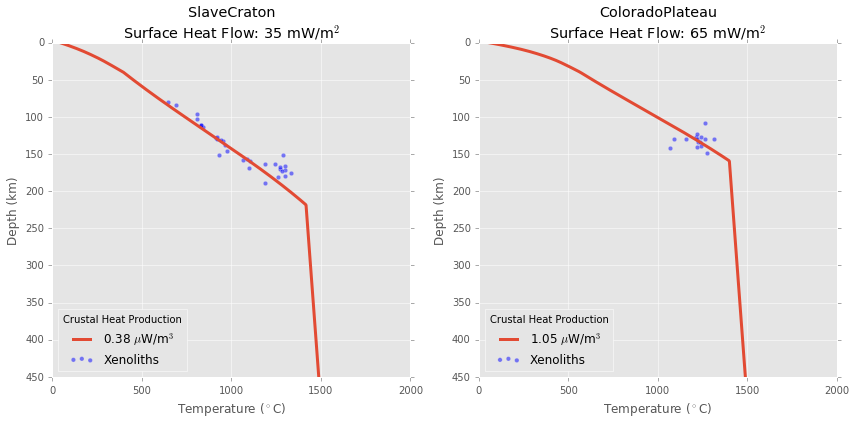

In [4]:
cases = {"SlaveCraton": 35e-3, "ColoradoPlateau": 65e-3}

from numpy import mean, std
import pandas as pd

df = pd.read_csv('Xenolith_geotherm_cad.csv')
df.columns  =  ['Country', 'Temperature', 'Pressure', 'Depth']

plt.figure(figsize=(12,6))
for iplt, case in enumerate(["SlaveCraton", "ColoradoPlateau"]):
    df1 = df.query("Country == '%s'" % case)
    q0  = cases[case]

    df0 = invert_for_geotherm(df1.Depth.tolist(), df1.Temperature.tolist(), q0=q0)

    #Mean and bounds and crustal heat production
    rhoHmean = mean(df0.rhoH)
    rhoHmin  = mean(df0.rhoH) - 2*std(df0.rhoH)
    rhoHmax  = mean(df0.rhoH) + 2*std(df0.rhoH)
    
    plt.subplot(1,2,iplt+1)
    for rhoH_crust in [rhoHmean]:
        depths, temps = example(rhoH_crust = rhoH_crust, q0=q0, draw_plot=True)
        
    gt = Geotherm(depths, temps, q0, rhoHmean, std(df0.rhoH), df1.Depth.tolist(), df1.Temperature.tolist())
    gt.save('geotherm_%s.pickle' % case)
        
    plt.xlim(0,2000)
    _,_=plt.ylabel('Depth (km)'), plt.xlabel('Temperature ($^\circ$C)')
    _ = plt.title('%s\nSurface Heat Flow: %2d mW/m$^2$' % (case,q0*1000))
    
    import pandas as pd
    _ = plt.scatter(df1.Temperature, df1.Depth,label='Xenoliths', alpha=0.5)
 
    plt.legend(loc=3, title="Crustal Heat Production")
    
plt.tight_layout()

In [15]:
!ls -lth *pickle

-rw-r--r--  1 mancinelli  staff    14K Jun  6 10:40 geotherm_ColoradoPlateau.pickle
-rw-r--r--  1 mancinelli  staff    13K Jun  6 10:39 geotherm_SlaveCraton.pickle
-rw-r--r--  1 mancinelli  staff   227B Jun  6 10:37 default_geotherm.pickle
